In [1]:
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch.optim as optim
import torch.utils.data as data

Prepare the economical data

In [2]:
raw_econ_df = pd.read_csv("data\Annual_FY_June2024.csv")

In [3]:
# fill the NaNs
econ_df = raw_econ_df.ffill()
econ_df = raw_econ_df.bfill()
econ_df.isna().sum().sum()

0

In [4]:
# add the inflation rate
econ_df['previous_cpiu'] = econ_df['cpiu'].shift(1)
econ_df['inflation_rate'] = ((econ_df['cpiu'] - econ_df['previous_cpiu']) / econ_df['previous_cpiu']) * 100
econ_df.drop(columns=['previous_cpiu'], inplace=True)
econ_df = econ_df.bfill()

Prepare the data for the model

In [5]:
dataset = econ_df.copy()

In [6]:
# the fed funds rate column is moved to the last position
column_to_move = 'fed_funds_rate'
column = dataset[column_to_move].copy()
dataset = dataset.drop(columns=[column_to_move])
dataset['fed_funds_rate'] = column

In [7]:
# date is an useless
dataset = dataset.drop(columns=['date']).copy()

In [8]:
# save the initial state

initial_data = dataset.tail(10).to_numpy().astype(float)
np.savetxt('initial_state.txt', initial_data, delimiter=',')

Prepare the data for the LSTM

In [9]:
# determine the size of the train/test-date  
train_size = int(len(econ_df) * 0.67)
test_size = len(econ_df) - train_size

In [10]:
# time series model 
class EcoModel(nn.Module):
    def __init__(self):
        super().__init__()
        input_dim = 78
        hidden_dim = 15
        layer_dim = 2
        output_dim = input_dim - 1 

        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_dim, batch_first=False)
        self.linear = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.linear(x)
        return x

In [11]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    dataset1 = dataset.copy()
    dataset2 = dataset.drop(dataset.columns[-1], axis=1).copy()
    for i in range(len(dataset)-lookback):
        feature = dataset1[i:i+lookback]
        target = dataset2[i+1:i+lookback+1]
        X.append(feature.values.astype(float))
        y.append(target.values.astype(float))
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [12]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
dataset = scaler.fit_transform(dataset)

dataset = pd.DataFrame(dataset)

train, test = dataset[:train_size], dataset[train_size:]  
lookback = 10
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

Training of the model

In [13]:
# create the model
model = EcoModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.L1Loss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=10)

In [14]:
# training of the model

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.8247, test RMSE 1.0503
Epoch 100: train RMSE 0.6138, test RMSE 1.1110


In [15]:
# save the model 
torch.save(model.state_dict(), "model_weights.pth")

Test the model

In [16]:
dataset = econ_df.copy()
column_to_move = 'fed_funds_rate'
column = dataset[column_to_move].copy()
dataset = dataset.drop(columns=[column_to_move])
dataset['fed_funds_rate'] = column
dataset = dataset.drop(columns=['date']).copy()
train, test = dataset[:train_size], dataset[train_size:]  
lookback = 10
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

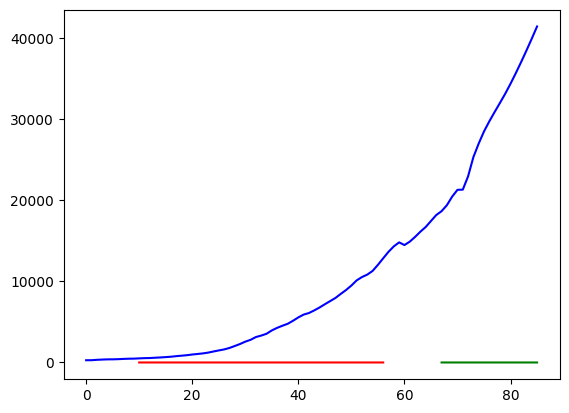

In [17]:
# evaluation
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(dataset['gdp']) * np.nan
    # y_pred = model(X_train)
    # y_pred = scalerX.inverse_transform(y_pred[:, -1, 0])
    rescaling_training_output = model(X_train)[:, -1, 0]
    train_plot[lookback:train_size] = rescaling_training_output
    # shift test predictions for plotting
    test_plot = np.ones_like(dataset['gdp']) * np.nan
    test_plot[train_size+lookback:len(dataset)] = model(X_test)[:, -1, 0]
# plot
plt.plot(dataset['gdp'], c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()